<a href="https://colab.research.google.com/github/Bhuvansai-16/Creditcard_frauddetection/blob/main/Creditfraud_adv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - AUC: 0.8769 - Precision: 0.8133 - Recall: 0.7864 - loss: 0.4199 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9234 - val_loss: 0.1444
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.9928 - Precision: 0.9720 - Recall: 0.9228 - loss: 0.0993 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9485 - val_loss: 0.0990
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.9966 - Precision: 0.9750 - Recall: 0.9476 - loss: 0.0725 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9684 - val_loss: 0.0698
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.9981 - Precision: 0.9760 - Recall: 0.9651 - loss: 0.0561 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9859 - val_loss: 0.0453
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.9989 - Precision: 0.9798 - Recall: 0.9784 - loss: 0.0426 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0

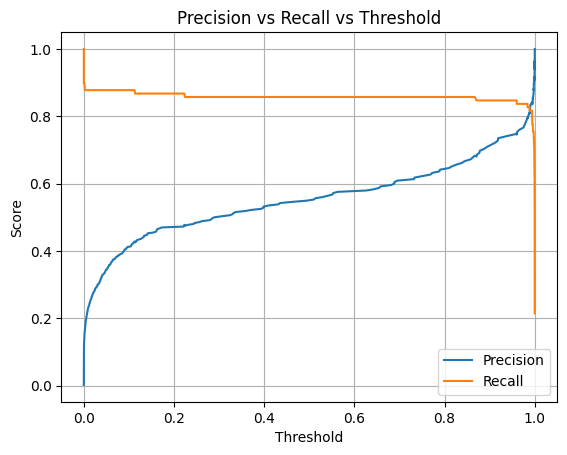

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve,accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#Load Data
df = pd.read_csv('creditcard.csv')
X = df.drop('Class', axis=1)
y = df['Class']

#Normalize
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

#Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

#Model
model = Sequential([
    Dense(64, input_shape=(X_smote.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['Precision', 'Recall', 'AUC'])

#Training the Model
history = model.fit(X_smote, y_smote,
                    epochs=20,
                    batch_size=2048,
                    validation_split=0.2)

#Predict Probabilities
y_pred_prob = model.predict(X_test)

#Find Best Threshold using F1-score
best_f1 = 0
best_thresh = 0.5
for thresh in np.arange(0.01, 1.0, 0.01):
    y_pred = (y_pred_prob > thresh).astype("int32")
    score = f1_score(y_test, y_pred)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"\n Best Threshold = {best_thresh:.2f} | Best F1 Score = {best_f1:.4f}")

#prediction
y_pred_final = (y_pred_prob > best_thresh).astype("int32")

#Evaluation
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_final, digits=4))
print("\n Accuracy score:",accuracy_score(y_test, y_pred_final))
# Step 11: Plot Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Tetsing 100 samples

new_test_samples = df.sample(n=100, random_state=123)

# Separate features and labels
X_new = new_test_samples.drop('Class', axis=1)
y_new = new_test_samples['Class']

# Scale Time and Amount using the already fitted scaler
X_new[['Time', 'Amount']] = scaler.transform(X_new[['Time', 'Amount']])

# Predict probabilities
y_new_pred_prob = model.predict(X_new)

# Use best threshold from tuning
best_threshold = 0.94
y_new_pred = (y_new_pred_prob > best_threshold).astype("int32")

#Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_new, y_new_pred))
print("\nClassification Report:\n", classification_report(y_new, y_new_pred, digits=4))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix:
 [[99  0]
 [ 0  1]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        99
           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000       100
   macro avg     1.0000    1.0000    1.0000       100
weighted avg     1.0000    1.0000    1.0000       100



In [16]:
# Save TensorFlow Keras model
model.save('fraud_detection_model.h5')

# Save scaler using pickle
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [17]:
import pandas as pd
import tensorflow as tf
import pickle

# Load model and scaler
model = tf.keras.models.load_model('fraud_detection_model.h5')
scaler = pickle.load(open('scaler.pkl', 'rb'))

# Take a subset of your original test data
X_test_sample = X_smote.sample(n=28, random_state=42)  # real data, not random
y_test_sample = y_smote.loc[X_test_sample.index]

# Scale Time and Amount columns
X_test_sample[['Time', 'Amount']] = scaler.transform(X_test_sample[['Time', 'Amount']])

# Apply threshold (for classification)
threshold = 0.94
pred_classes = (y_pred > threshold).astype(int)

print("Predicted classes:\n", pred_classes)
print("Actual classes:\n", y_test_sample.values)


Predicted classes:
 [[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Actual classes:
 [0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0]


In [18]:
#Testing
model = tf.keras.models.load_model('fraud_detection_model.h5')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
#10000 samples
X_test_sample = X_smote.sample(n=10000, random_state=42)
y_test_sample = y_smote.loc[X_test_sample.index]

X_test_sample[['Time', 'Amount']] = scaler.transform(X_test_sample[['Time', 'Amount']])

# Predict probabilities
y_probs = model.predict(X_test_sample)

# Apply the best threshold
BEST_THRESHOLD = 0.94
y_preds = (y_probs > BEST_THRESHOLD).astype(int)

# Print evaluation metrics
print(" Confusion Matrix:\n", confusion_matrix(y_test_sample, y_preds))
print("\nClassification Report:\n", classification_report(y_test_sample, y_preds, digits=4))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 Confusion Matrix:
 [[4943    0]
 [ 676 4381]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8797    1.0000    0.9360      4943
           1     1.0000    0.8663    0.9284      5057

    accuracy                         0.9324     10000
   macro avg     0.9398    0.9332    0.9322     10000
weighted avg     0.9405    0.9324    0.9321     10000

